In [ ]:
import pandas as pd
import numpy as np
import cv2
import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, Lambda, Dense, Flatten,MaxPooling2D, ZeroPadding2D,  Dropout, BatchNormalization
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import binary_crossentropy

from sklearn.metrics import classification_report, confusion_matrix

import numpy.random as rng
import random
import numpy as np
import os
from tqdm import tqdm
from matplotlib import pyplot as plt

import config
import CustomDataGenerator
import model

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 1


In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [ ]:
EPOCHS = config.EPOCHS
BATCH_SIZE = config.BATCH_SIZE
VAL_BATCH_SIZE = config.VAL_BATCH_SIZE
TARGET_SIZE = config.TARGET_SIZE
INPUT_SIZE = config.INPUT_SIZE
NUM_CLASSES = config.NUM_CLASSES
LEARNING_RATE = config.LEARNING_RATE
CLASSES = config.CLASSES

In [ ]:
train_csv = './dataset/train_data.csv'
val_csv = './dataset/val_data.csv'
test_csv = './dataset/test_data.csv'

In [ ]:
train_df = pd.read_csv(train_csv, encoding='utf-8')
val_df = pd.read_csv(val_csv, encoding='utf-8')
test_df = pd.read_csv(test_csv, encoding='utf-8')

In [ ]:
train_df.drop('sample', axis=1, inplace=True)
val_df.drop('sample', axis=1, inplace=True)
test_df.drop('sample', axis=1, inplace=True)

In [ ]:
def get_absolute_path(path):
    return os.path.join(os.curdir, path)

train_df["image1"] = train_df["image1"].apply(get_absolute_path)
train_df["image2"] = train_df["image2"].apply(get_absolute_path)
val_df["image1"] = val_df["image1"].apply(get_absolute_path)
val_df["image2"] = val_df["image2"].apply(get_absolute_path)
test_df["image1"] = test_df["image1"].apply(get_absolute_path)
test_df["image2"] = test_df["image2"].apply(get_absolute_path)

In [ ]:
columns = ["image1", "image2", "label"]
train_df.columns = columns
val_df.columns = columns
test_df.columns = columns

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43276 entries, 0 to 43275
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image1  43276 non-null  object
 1   image2  43276 non-null  object
 2   label   43276 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1014.4+ KB


In [ ]:
train_df.head()

,image1,image2,label
0,ds/real/0008/0008_00_00_02_199.jpg,ds/real/0008/0008_00_00_02_296.jpg,1
1,ds/real/0009/0009_01_00_02_384.jpg,ds/fake/0009/0009_01_04_03_56.jpg,0
2,ds/real/0004/0004_01_00_01_406.jpg,ds/real/0004/0004_01_06_03_454.jpg,1
3,ds/real/0009/0009_01_00_02_116.jpg,ds/real/0009/0009_01_00_02_181.jpg,1
4,ds/real/0001/0001_00_00_01_52.jpg,ds/fake/0001/0001_00_02_02_63.jpg,0


In [ ]:
test_df.head()

,image1,image2,label
0,ds/real/0012/0012_01_07_03_118.jpg,ds/real/0012/0012_01_07_03_137.jpg,1
1,ds/real/0012/0012_01_07_03_38.jpg,ds/real/0012/0012_01_07_03_480.jpg,1
2,ds/real/0012/0012_01_07_03_470.jpg,ds/real/0012/0012_01_07_03_487.jpg,1
3,ds/real/0012/0012_01_07_03_264.jpg,ds/real/0012/0012_01_07_03_477.jpg,1
4,ds/real/0012/0012_01_07_03_161.jpg,ds/real/0012/0012_01_07_03_351.jpg,1


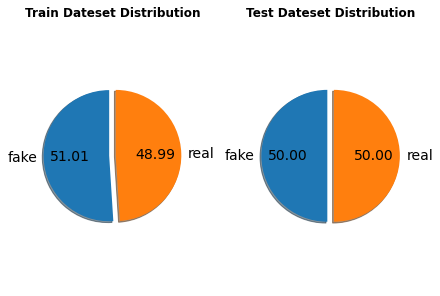

In [ ]:
fig1, (ax1,ax2) = plt.subplots(1,2, constrained_layout=True)
ax1.pie([train_df['label'].value_counts()[0], train_df['label'].value_counts()[1]],
        labels=["fake", "real"],
        autopct = '%.2f',
        shadow=True, 
        startangle=90,
        textprops={'fontsize': 14},
        explode=(0.1,0)
         )
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title('Train Dateset Distribution', fontweight='bold')

ax2.pie([test_df['label'].value_counts()[0], test_df['label'].value_counts()[1]],
        labels=["fake", "real"],
        autopct = '%.2f',
        shadow=True, 
        startangle=90,
        textprops={'fontsize': 14},
        explode=(0.1,0)
         )
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax2.set_title('Test Dateset Distribution', fontweight='bold')
plt.show()

Text(0.5, 0.98, 'Real - Real Pair (Label:1)')

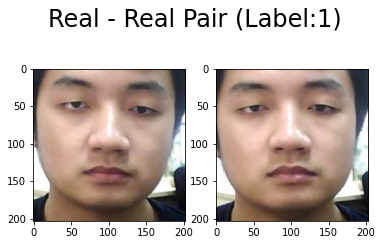

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
img1 = plt.imread(train_df.image1[0])
ax1.imshow(img1)
ax2 = fig.add_subplot(1,2,2)
img2 = plt.imread(train_df.image2[0])
ax2.imshow(img2)
fig.suptitle('Real - Real Pair (Label:1)', fontsize=24)

Text(0.5, 0.98, 'Real - Fake Pair (Label:0)')

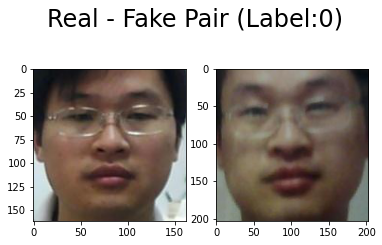

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
img1 = plt.imread(train_df.image1[1])
ax1.imshow(img1)
ax2 = fig.add_subplot(1,2,2)
img2 = plt.imread(train_df.image2[1])
ax2.imshow(img2)
fig.suptitle('Real - Fake Pair (Label:0)', fontsize=24)

In [ ]:
traingen = CustomDataGenerator.CustomDataGen(train_df,
                      X_col={'img1_path':'image1', 'img2_path': 'image2'},
                      y_col={'labels': 'label'},
                      batch_size=BATCH_SIZE, input_size=TARGET_SIZE, shuffle=True)

valgen = CustomDataGenerator.CustomDataGen(val_df,
                       X_col={'img1_path':'image1', 'img2_path': 'image2'},
                       y_col={'labels': 'label'},
                       batch_size=BATCH_SIZE, input_size=TARGET_SIZE, shuffle=True)

testgen = CustomDataGenerator.CustomDataGen(test_df,
                       X_col={'img1_path':'image1', 'img2_path': 'image2'},
                       y_col={'labels': 'label'},
                       batch_size=BATCH_SIZE, input_size=TARGET_SIZE, shuffle=True)

In [ ]:
pair, label = valgen[0]
print(pair[0].shape)
print(pair[1].shape)
print(label.shape)
print(len(valgen))

(128, 64, 64, 3)
(128, 64, 64, 3)
(128,)
84


(128, 64, 64, 3)
(128, 64, 64, 3)
(128,)


Text(0.5, 0.98, 'Label:1')

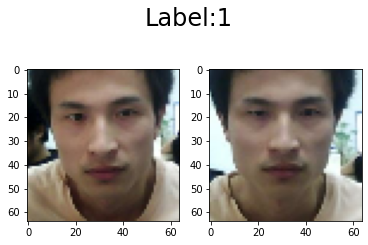

In [ ]:
pair, label = traingen[70]
print(pair[0].shape)
print(pair[1].shape)
print(label.shape)
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
#img1 = plt.imread(img1[0])
ax1.imshow(pair[0][0,:,:,:])
ax2 = fig.add_subplot(1,2,2)
#img2 = plt.imread(img2[0])
ax2.imshow(pair[1][0,:,:,:])
fig.suptitle(f'Label:{int(label[0])}', fontsize=24)

In [ ]:
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

def eucl_distance_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def contrastive_loss(y_true, y_pred, margin=1):
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

In [ ]:
base_network = model.Siamese((64,64,3))

input_a = Input(shape=(64,64,3))
input_b = Input(shape=(64,64,3))

processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance, output_shape=eucl_distance_shape)([processed_a, processed_b])
#prediction = Dense(1,activation='sigmoid',bias_initializer=model.initialize_bias)(distance)

siamese_model = Model(inputs=[input_a, input_b], outputs=distance)
siamese_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 240)          6650796     input_7[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 1)            0           sequential_3[0][0]         

In [ ]:
rms = tf.keras.optimizers.RMSprop(learning_rate=1e-4, rho=0.9, epsilon=1e-08)
siamese_model.compile(loss=contrastive_loss, optimizer=rms)

In [ ]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=2, min_lr=0.000001, verbose=1),
    ModelCheckpoint('./siamese.h5', verbose=1, save_weights_only=True, save_best_only=True)
]

In [ ]:
H = siamese_model.fit(traingen,
          steps_per_epoch= len(train_df)//BATCH_SIZE,
          validation_data= valgen,
          validation_steps= len(val_df)//BATCH_SIZE,
          epochs=EPOCHS,
          callbacks=callbacks,
          verbose= 1)

Epoch 1/20
338/338 [==============================] - 242s 712ms/step - loss: 0.2027 - val_loss: 0.0678

Epoch 00001: val_loss improved from inf to 0.06779, saving model to /siamese.h5
Epoch 2/20
338/338 [==============================] - 205s 607ms/step - loss: 0.0573 - val_loss: 0.0593

Epoch 00002: val_loss improved from 0.06779 to 0.05929, saving model to /siamese.h5
Epoch 3/20
338/338 [==============================] - 206s 609ms/step - loss: 0.0305 - val_loss: 0.0187

Epoch 00003: val_loss improved from 0.05929 to 0.01871, saving model to /siamese.h5
Epoch 4/20
338/338 [==============================] - 206s 609ms/step - loss: 0.0193 - val_loss: 0.0119

Epoch 00004: val_loss improved from 0.01871 to 0.01194, saving model to /siamese.h5
Epoch 5/20
338/338 [==============================] - 205s 606ms/step - loss: 0.0115 - val_loss: 0.0074

Epoch 00005: val_loss improved from 0.01194 to 0.00745, saving model to /siamese.h5
Epoch 6/20
338/338 [==============================] - 205s 

In [ ]:
siamese_model.load_weights("./siamese.h5")
siamese_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 240)          6650796     input_7[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 1)            0           sequential_3[0][0]         

In [ ]:
def compute_accuracy_roc(predictions, labels):
    '''Compute ROC accuracy with a range of thresholds on distances.
    '''
    dmax = np.max(predictions)
    dmin = np.min(predictions)
    nsame = np.sum(labels == 1)
    ndiff = np.sum(labels == 0)
   
    step = 0.01
    max_acc = 0
    best_thresh = -1
   
    for d in np.arange(dmin, dmax+step, step):
        idx1 = predictions.ravel() <= d
        idx2 = predictions.ravel() > d
       
        tpr = float(np.sum(labels[idx1] == 1)) / nsame       
        tnr = float(np.sum(labels[idx2] == 0)) / ndiff
        acc = 0.5 * (tpr + tnr)       
#       print ('ROC', acc, tpr, tnr)
       
        if (acc > max_acc):
            max_acc, best_thresh = acc, d
           
    return max_acc, best_thresh

In [ ]:
pred, tr_y = [], []
test_iter = iter(testgen)
for i in tqdm(range(len(test_df) // BATCH_SIZE) + 1):
    (img1, img2), label = next(test_iter)
    tr_y.extend(label)
    pred.extend(siamese_model.predict([img1, img2])[:, 0])

100%|██████████| 156/156 [01:18<00:00,  1.98it/s]


In [ ]:
tr_acc, threshold = compute_accuracy_roc(np.array(pred), np.array(tr_y))
tr_acc, threshold

(0.9932853932584269, 0.51)

In [ ]:
def predict_score(testgen, num_samples=10):
    '''Predict distance score and classify test images as Genuine or Forged'''
    for _ in range(num_samples):
        testgen_idx = random.randint(0, len(testgen))
        test_point, test_label = testgen[testgen_idx]
        img1, img2 = test_point[0], test_point[1]
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 10))
        ax1.imshow((np.squeeze(img1) * 255).astype(np.uint8), cmap='gray')
        ax2.imshow((np.squeeze(img2) * 255).astype(np.uint8), cmap='gray')
        ax1.set_title('Genuine')
        if test_label == 1:
            ax2.set_title('Genuine')
        else:
            ax2.set_title('Forged')
        ax1.axis('off')
        ax2.axis('off')
        plt.show()
        result = siamese_model.predict([img1, img2])
        diff = result[0][0]
        print("Difference Score = ", diff)
        if diff > threshold:
            print("Its a Forged Face")
        else:
            print("Its a Genuine Face")
    
    plt.show()

In [ ]:
testgen = CustomDataGenerator.CustomDataGen(test_df,
                       X_col={'img1_path':'image1', 'img2_path': 'image2'},
                       y_col={'labels': 'label'},
                       batch_size=1, input_size=TARGET_SIZE, shuffle=True)

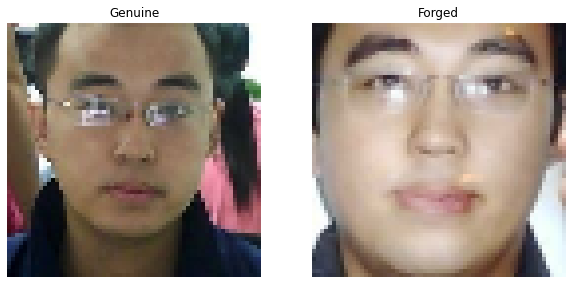

Difference Score =  1.353199
Its a Forged Face


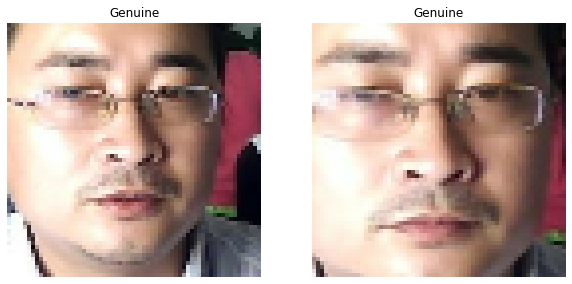

Difference Score =  0.0
Its a Genuine Face


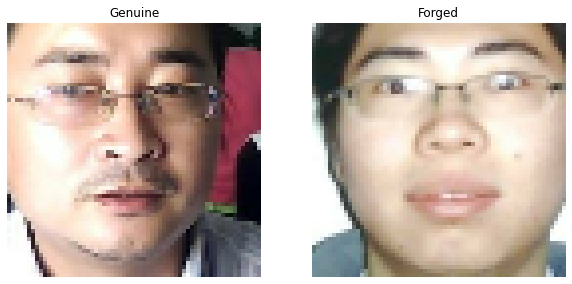

Difference Score =  1.1713057
Its a Forged Face


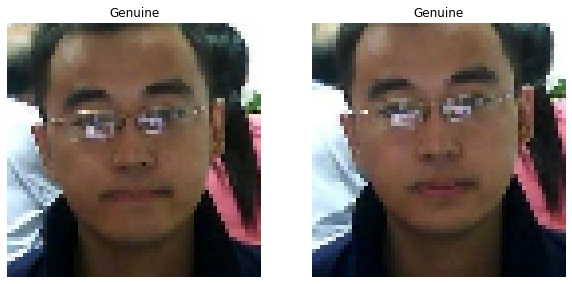

Difference Score =  0.0
Its a Genuine Face


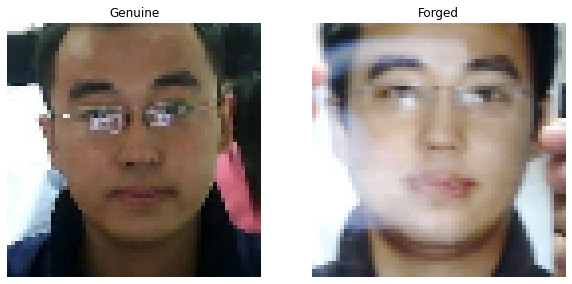

Difference Score =  1.035602
Its a Forged Face


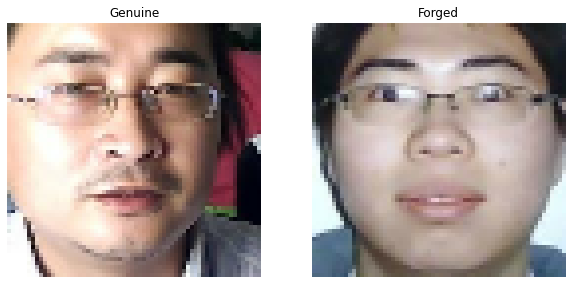

Difference Score =  1.7840894
Its a Forged Face


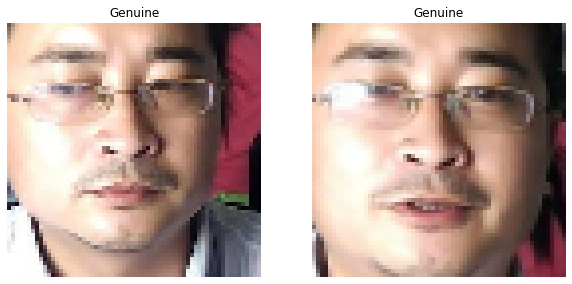

Difference Score =  0.0
Its a Genuine Face


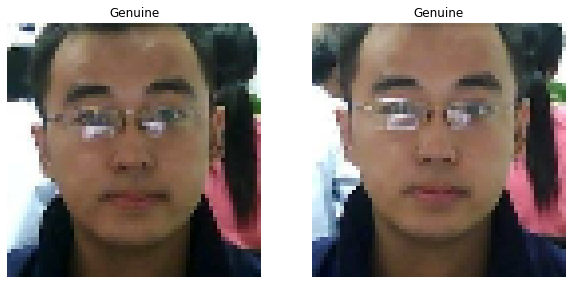

Difference Score =  0.0
Its a Genuine Face


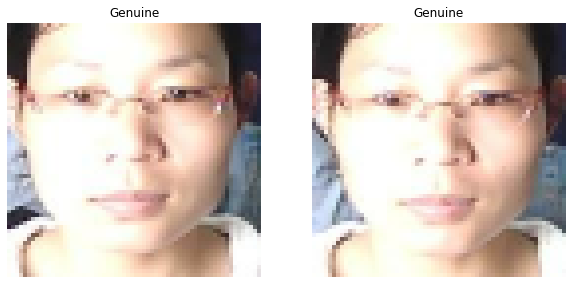

Difference Score =  0.0
Its a Genuine Face


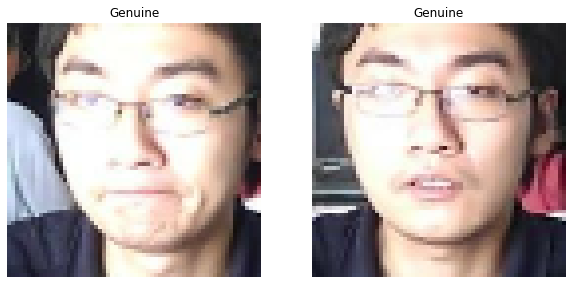

Difference Score =  0.0
Its a Genuine Face


In [ ]:
predict_score(testgen)